# Supervised learning- regression

A real estate agent currently only has Single-Family housed in his portfolio. He wants to expand his business to apartments, but he doesn't have enough experience to give reliable appraisels. Getting the necessary experience would take a lot of time and he doesn't have any colleagues to fall back on. He knows we are following a machine learning course and has a brilliant idea. He give us a data-set with a lot of information on real estate, including the known selling price (tx_price).  He asks us to build a real-estate pricing model for apartmens.

We already cleaned this dataset in the first class (the data hasn't been standardized yet). Perform a simple linear regression and polynomial regression to predict the price for apartments.

## 0. Loading packages and dataset

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('real_estate_cleaned.csv')

The dataset is already cleaned, but not standardized yet. We will take a quick look at the data to get to know the dataset.

# 1. Take a look at the data
1. Look at the dimensions (number of features and observations)
2. Look at the first 5 rows
3. Look at the different features and there data types
    + What do you notice with regard to the datatypes of the one-hot encoded features?
    + Fix this




1. Dimensions

In [ ]:
df.shape

2. First rows

In [ ]:
df.head()

3. Data types

In [ ]:
df.info()

You should have noticed that they are not in the correct data type. Convert them to uint8, using '.astype(np.uint8)'

In [ ]:
df.iloc[:,25:39] = df.iloc[:,25:39].astype(np.uint8)

In [ ]:
df.info()

# 2 Train/test-split and standardisation

1. Shuffle your data

2. Make a Train/test - Use random state=123 whenever needed
    
3. Standardize both datasets  
    + Make sure you only standardise the numerical features


1. Shuffle

In [ ]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)


2. Train/test-split

In [ ]:
# Import the function
from sklearn.model_selection import train_test_split

# Split of feaures and outcomes
X = df_shuffle.drop(columns='tx_price')
y = df_shuffle['tx_price']

# Perform train/test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


3. Standardise

In [ ]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train_stan = X_train.copy()
X_test_stan = X_test.copy()

X_train_stan[num_feat] = scaler.transform(X_train[num_feat])
X_test_stan[num_feat] = scaler.transform(X_test[num_feat])


# 3. Linear regression
1. Train a linear regression model, using the standardized data.
2. Test the trained model on the train and the test set.
    + Predict the price of the appartments
    + Calculate the coefficient of determination
    + Calculate the Mean Absolute Error (MAE)
    + Calculate the Mean Square Error (MSE)
    + Would you say this model is overfitted, underfitted or neither?



1. Train

In [ ]:
from sklearn.linear_model import LinearRegression
reg= LinearRegression()
reg.fit(X_train_stan, y_train)
print("The coefficients are: ", reg.coef_, " \n The intercept is ", reg.intercept_)

In [ ]:
k=0
for i in reg.coef_:
    print(i , "* ", X_train.columns[k], " + ")
    k=k+1
print(" + ", reg.intercept_)

2. Evaluating the model
    + make predictions

In [ ]:
predictions_train = reg.predict(X_train_stan)
predictions_test = reg.predict(X_test_stan)

   + Coefficient of determination

In [ ]:
print(reg.score(X_train_stan, y_train))
print(reg.score(X_test_stan, y_test))

In [ ]:
#alternative code
from sklearn.metrics import r2_score
print(r2_score(y_train, predictions_train))
print(r2_score(y_test, predictions_test))


+ MAE


In [ ]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, predictions_train))
print(mean_absolute_error(y_test, predictions_test))


+ MSE

In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_train, predictions_train))
print(mean_squared_error(y_test, predictions_test))


The test R^2 is not a lot lower than the training R^2. This means our model is not a lot overfitted. An R^2 of 54,8% is not very high, so our model might be underfitted. 

# 2. Polynomial regression
## 2.1 Quadratic model

We will do a quadratic polynomial regression to see if we can improve the reliability of the model. 
1. Design polynomial features with degree 2
    + Don't forget to also transform the test data
    + Check the number of features of the new datasets 
2. Fit a linear regression to the polynomial features
    + Use the 'fit_intercept=False'-argument
3. Evaluate the train and test-set, using R^2 
    +  Would you say this model is overfitted, underfitted or neither?



1. Design the features

In [33]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_stan)
X_test_poly = poly.transform(X_test_stan)


In [34]:
#check the number of features
X_train_poly.shape

(642, 780)

2. Fit the linear regression

In [35]:
reg_quad = LinearRegression(fit_intercept=False)
reg_quad.fit(X_train_poly, y_train)


LinearRegression(fit_intercept=False)

In [36]:
print(reg_quad.score(X_train_poly, y_train))
print(reg_quad.score(X_test_poly, y_test))

0.9911705428351142
-5631.044493371921


This model is clearly overfitted. It can almost perfectly predict the prices of the training set, but fails miserably when trying to predict the prices in the test dataset. It clearly has just remembered the prices in the dataset by heart instead of searching for patterns. (Once again, note that we are just using the test set here, so you can learn about underfit and overfit. Do not use it to compare algorithms)

## 2.2 Higher order polynomial model

1. Do a cross-validation to find the optimal order for the polynomial.
    + Use a pipeline that entails two steps: engineering the polynomial features and fitting the regression
    + Let the degree of the polynomial range from 1 to 4.
    + Ask python to print out the R^2 for each degree
    + What do you expect to happen? Will increasing the degree of the polynomial solve the overfitting or just make it worse?
    
2. Make a plot of the cross-validation results
     + Did your expectation come true?
    + Overfitted or underfitted?

1. Cross-validation

In [37]:
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

avg_scores = [None] * 5

for i in np.arange(1,5):
    
    reg_poly = Pipeline([('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train_stan, y_train, scoring = 'r2', cv=5)
    
    avg_scores[i-1] = scores.mean()
    
    print("Order "+str(i)+": avg R^2 = "+str( avg_scores[i-1]))

Order 1: avg R^2 = 0.5331973447169984
Order 2: avg R^2 = -41.502029366696824
Order 3: avg R^2 = -87.30806747049651
Order 4: avg R^2 = -424.8221244924031


2. plot

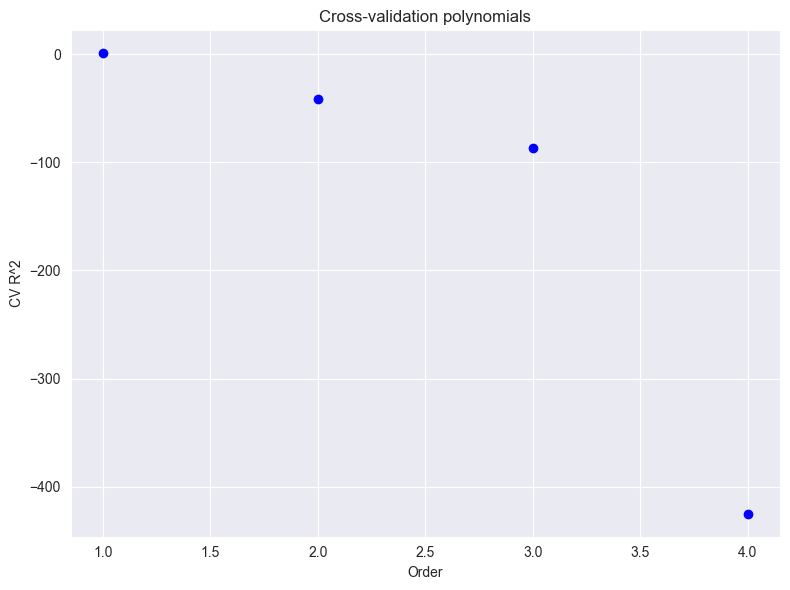

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.scatter(np.arange(1,6), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order");
ax.set_ylabel("CV R^2");
plt.tight_layout()
plt.show()

We can clearly see that the overfitting gets worse and worse when the order increases. This is because our model becomes more and more complex, meaning it can memorize the prices even better. The downside is that it is no longer able to find the real patterns and can thus no longer predict prices of a new dataset.

When the degree is 2, the number of features is already higher than the number of observations, which will only become worse when the degree increases. When this happens, the model will by definition be overfitted. In the next class, we will see how we can solve this.

